### Классификация
#### 1. Импортируем библиотеки и датасет (геометрические свойства трех видов пшеницы).

In [394]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn import tree,ensemble,model_selection,metrics,neighbors
from warnings import filterwarnings as fw
fw('ignore')

In [338]:
data = pd.read_csv('seeds.csv')
data.head()

,area,perimeter,compactness,kernellength,kernelwidth,assymetry,groovelength,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


Отберем в отдельные датафреймы характеристики объектов и метки классов. 
<br>Затем поделим датасет на обучающую и тестовую выборки.

In [339]:
x = data.iloc[:,:7]
y = data.iloc[:,7:]
xtrain,xtest,ytrain,ytest = model_selection.train_test_split(x,y,test_size=0.2)
print('xtrain: ', xtrain.shape, 'ytrain: ', ytrain.shape, '\nxtest: ', xtest.shape, 'ytest: ', ytest.shape)
ytest=ytest.to_numpy().flatten()

xtrain:  (168, 7) ytrain:  (168, 1) 
xtest:  (42, 7) ytest:  (42, 1)


#### 2. Построим дерево решений со значениями по умолчанию.

In [392]:
DTC = tree.DecisionTreeClassifier()
DTC.fit(xtrain,ytrain)
ypred = DTC.predict(xtest)

Оценим результат с помощью таких метрик, как precision, recall, f1-score, а также AUC и матриц ошибок.

In [391]:
print(metrics.classification_report(ytest,ypred,digits=5))
print('AUC = ', metrics.roc_auc_score(ytest,DTC.predict_proba(xtest),average='macro',multi_class='ovr'))

              precision    recall  f1-score   support

           1    1.00000   0.80000   0.88889        10
           2    1.00000   1.00000   1.00000        11
           3    0.91304   1.00000   0.95455        21

    accuracy                        0.95238        42
   macro avg    0.97101   0.93333   0.94781        42
weighted avg    0.95652   0.95238   0.95082        42

AUC =  0.9507936507936506


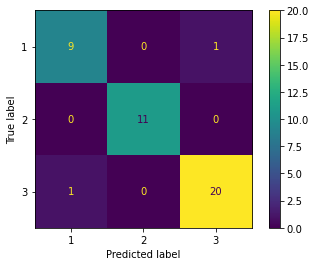

In [385]:
metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(ytest,ypred), display_labels=DTC.classes_).plot()

Пусть наш целевой класс - 1, тогда матрица ошибок будет иметь следующий вид:

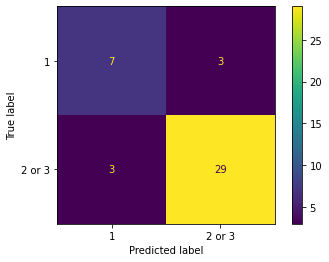

In [343]:
metrics.ConfusionMatrixDisplay(confusion_matrix=np.array([[7, 3],[3, 29]]), display_labels=['1','2 or 3']).plot()

In [344]:
KNN = neighbors.KNeighborsClassifier()
ytr = ytrain.to_numpy().flatten()
knnclasser = KNN.fit(xtrain,ytr)

In [345]:
ypredKNN = knnclasser.predict(xtest)
print(metrics.classification_report(ytest,ypredKNN,digits=5))

              precision    recall  f1-score   support

           1    0.80000   0.80000   0.80000        10
           2    1.00000   0.90909   0.95238        11
           3    0.90909   0.95238   0.93023        21

    accuracy                        0.90476        42
   macro avg    0.90303   0.88716   0.89420        42
weighted avg    0.90693   0.90476   0.90503        42



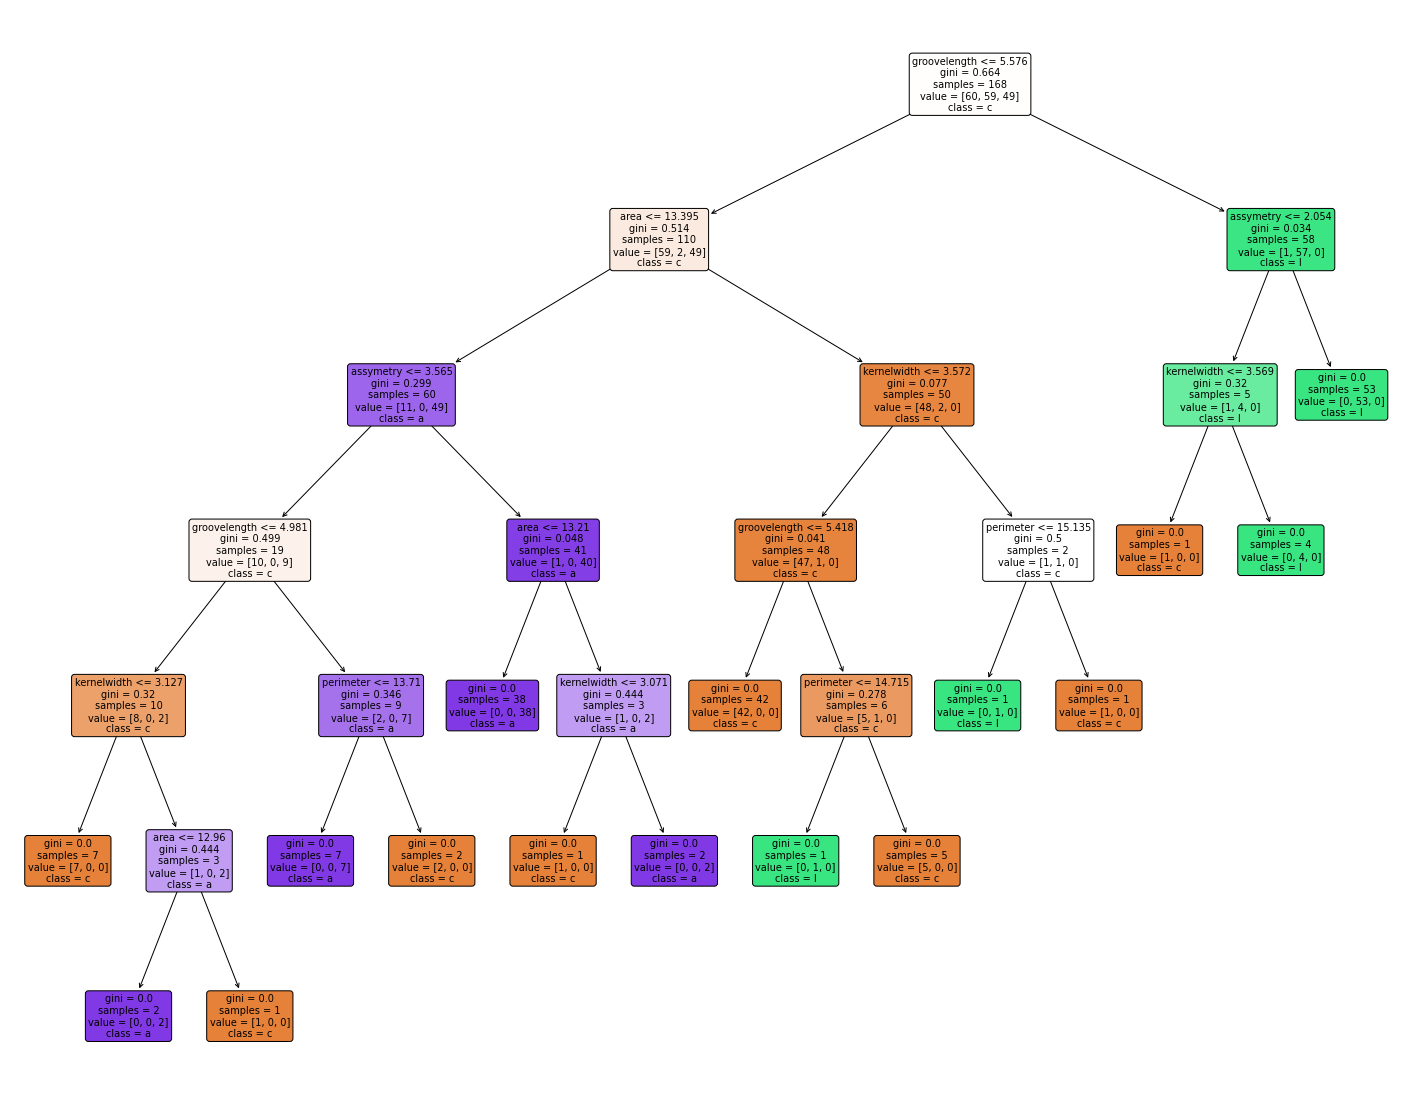

In [393]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DTC, 
                   feature_names=['area','perimeter','compactness','kernellength','kernelwidth','assymetry','groovelength'],  
                   class_names='class',
                   filled=True,
                   rounded=True)


In [347]:
RFC = ensemble.RandomForestClassifier()
RFC.fit(xtrain,ytrain.to_numpy().flatten())
ypredRFC = RFC.predict(xtest)
print(metrics.classification_report(ytest,ypredRFC,digits=5))

              precision    recall  f1-score   support

           1    0.88889   0.80000   0.84211        10
           2    1.00000   1.00000   1.00000        11
           3    0.90909   0.95238   0.93023        21

    accuracy                        0.92857        42
   macro avg    0.93266   0.91746   0.92411        42
weighted avg    0.92809   0.92857   0.92752        42



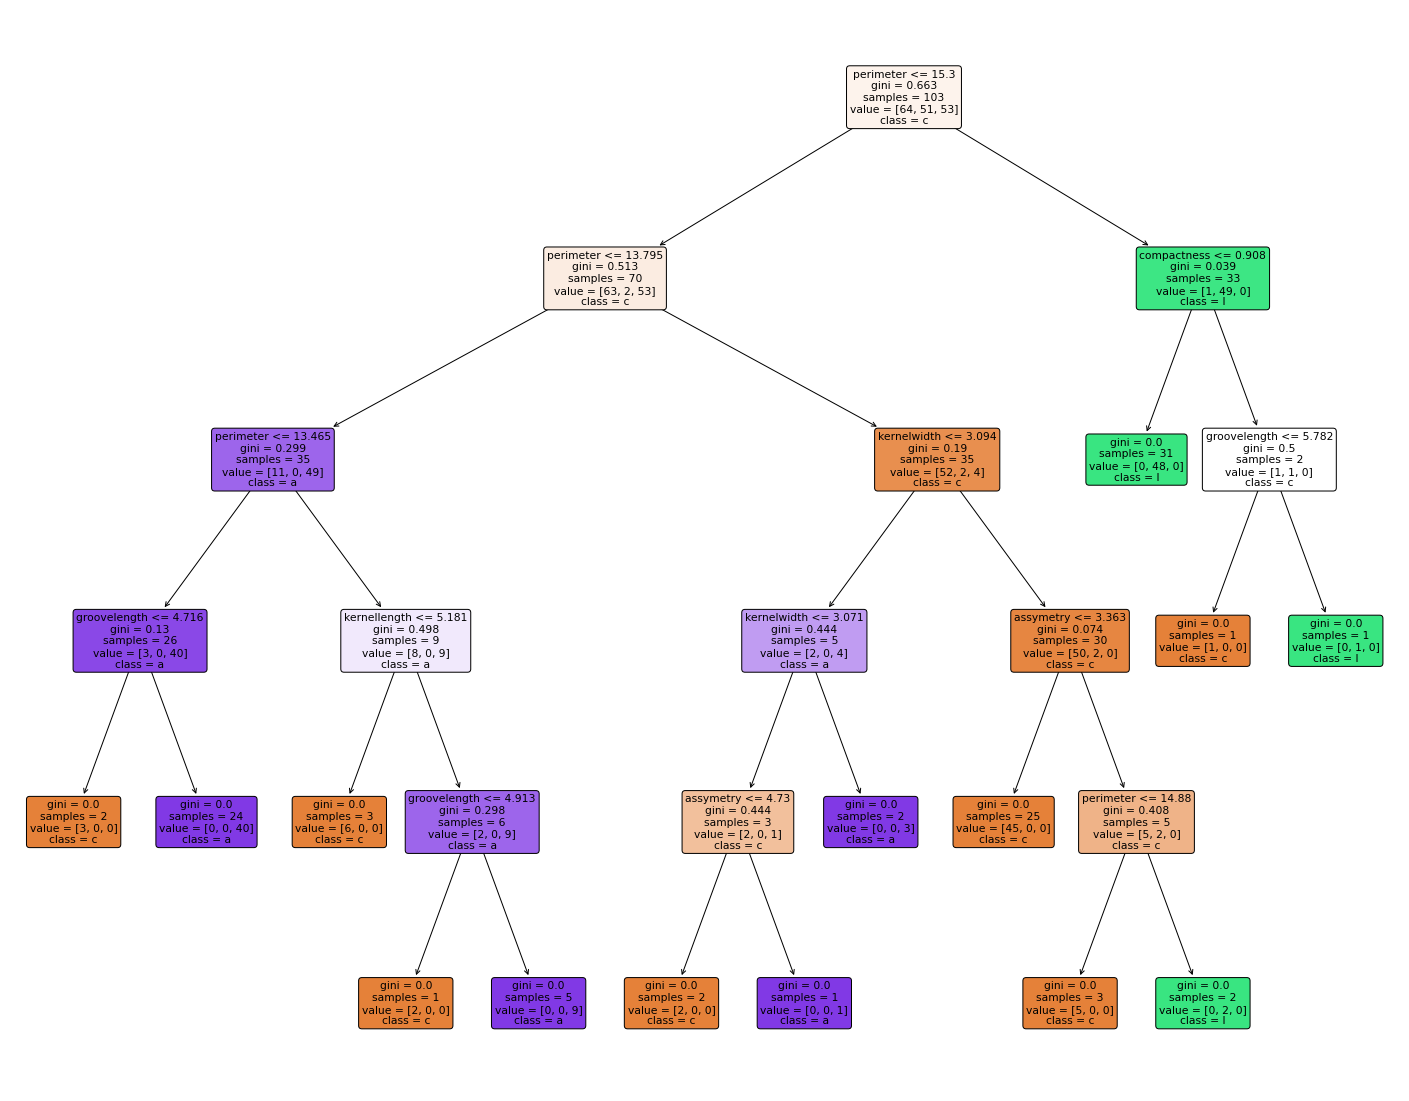

In [348]:
fig = plt.figure(figsize=(25,20))
a = tree.plot_tree(RFC.estimators_[0], 
                   feature_names=['area','perimeter','compactness','kernellength','kernelwidth','assymetry','groovelength'],  
                   class_names='class',
                   filled=True,
                   rounded=True)

#### 3. Исследуем слияние параметров на качество классификации.

#### 4. Оценим важность показателей с помощью RandomForest.

In [349]:
for i in range(7):
    print(data.columns[i], ' - ', RFC.feature_importances_[i])

area  -  0.14116260385226914
perimeter  -  0.22360888241378699
compactness  -  0.0577594173693043
kernellength  -  0.1382146144134399
kernelwidth  -  0.1461548370476087
assymetry  -  0.08747308642140768
groovelength  -  0.20562655848218334


Таким образом, наши показатели в порядке убывания важности:
<br> perimeter > groovelength > kernelwidth > area > kernellength > assymetry > compactness

#### 5. Построение моделей Decision tree на полном наборе показателей, на 20% самых важных, на 80% наименее важных.

#### 6. Коллективные древовидные модели на базе бустинга: AdaBoost и GradientBoost
Используем AdaBoost со значениями по умолчанию:
<br> Оценим результат с помощью таких метрик, как precision, recall, f1-score, а также AUC и матриц ошибок.

In [383]:
ABC = ensemble.AdaBoostClassifier()
ABC.fit(xtrain,ytrain)
ABCpred = ABC.predict(xtest)
print(metrics.classification_report(ytest,ABCpred,digits=5))
print('AUC = ', metrics.roc_auc_score(ytest,ABC.predict_proba(xtest),average='macro',multi_class='ovr'))

              precision    recall  f1-score   support

           1    0.32258   1.00000   0.48780        10
           2    1.00000   1.00000   1.00000        11
           3    0.00000   0.00000   0.00000        21

    accuracy                        0.50000        42
   macro avg    0.44086   0.66667   0.49593        42
weighted avg    0.33871   0.50000   0.37805        42

AUC =  0.8112599206349206


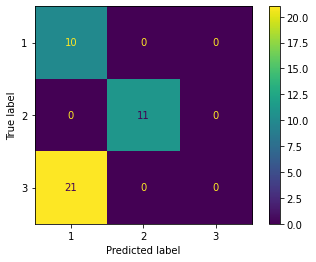

In [384]:
metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(ytest,ABCpred), display_labels=DTC.classes_).plot()

Теперь используем дерево решений, построенное в пункте 2 в качестве базового классификатора, чтобы получить лучший результат.

In [375]:
ABC = ensemble.AdaBoostClassifier(base_estimator=DTC)
ABC.fit(xtrain,ytrain)
ABCpred = ABC.predict(xtest)
print(metrics.classification_report(ytest,ABCpred,digits=5))
print('AUC = ', metrics.roc_auc_score(ytest,ABC.predict_proba(xtest),average='macro',multi_class='ovr'))

              precision    recall  f1-score   support

           1    0.88889   0.80000   0.84211        10
           2    0.91667   1.00000   0.95652        11
           3    0.95238   0.95238   0.95238        21

    accuracy                        0.92857        42
   macro avg    0.91931   0.91746   0.91700        42
weighted avg    0.92791   0.92857   0.92721        42

AUC =  0.9402089733742959


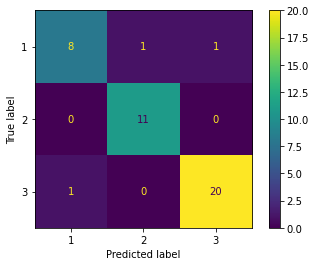

In [381]:
metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(ytest,ABCpred), display_labels=DTC.classes_).plot()

Используем GradientBoost со значениями по умолчанию:

In [379]:
GBC = ensemble.GradientBoostingClassifier()
GBC.fit(xtrain,ytrain)
GBCpred = GBC.predict(xtest)
print(metrics.classification_report(ytest,GBCpred,digits=5))
print('AUC = ', metrics.roc_auc_score(ytest,GBC.predict_proba(xtest),average='macro',multi_class='ovr'))

              precision    recall  f1-score   support

           1    0.90000   0.90000   0.90000        10
           2    1.00000   1.00000   1.00000        11
           3    0.95238   0.95238   0.95238        21

    accuracy                        0.95238        42
   macro avg    0.95079   0.95079   0.95079        42
weighted avg    0.95238   0.95238   0.95238        42

AUC =  0.9964049508692366


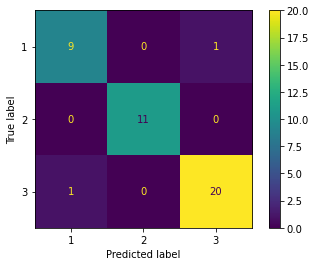

In [380]:
metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(ytest,GBCpred), display_labels=DTC.classes_).plot()